In [58]:
import pandas as pd
import numpy as np
import ateam.data.lims as lims
import seaborn as sns
import matplotlib.pyplot as plt
# fix slow autocomplete in py3
%config Completer.use_jedi = False

In [167]:
lr = lims.LimsReader()
cells_df = lr.get_cells_df(project_code="hIVSCC-MET", has_reconstruction=True)

print("{} cells with reconstructions".format(cells_df.shape[0]))

240 cells with reconstructions


In [162]:
cells_df["triblips"] = [len(lr.get_sweeps(cell_id=id, sweep_type="Triple")) for id in cells_df.index]
cells_df["chirps"] = [len(lr.get_sweeps(cell_id=id, description="CHIRP")) for id in cells_df.index]
cells_df["spiking"] = [len(lr.get_sweeps(cell_id=id, sweep_type="Long Square", spiking=True, depolarizing=True)) for id in cells_df.index]
cells_df["sub_depol"] = [len(lr.get_sweeps(cell_id=id, sweep_type="Long Square", spiking=False, depolarizing=True)) for id in cells_df.index]
cells_df["sub_hyper"] = [len(lr.get_sweeps(cell_id=id, sweep_type="Long Square", spiking=False, depolarizing=False)) for id in cells_df.index]

cells_df["triblips_passed"] = [len(lr.get_sweeps(cell_id=id, passed_only=True, sweep_type="Triple")) for id in cells_df.index]
cells_df["chirps_passed"] = [len(lr.get_sweeps(cell_id=id, passed_only=True, description="CHIRP")) for id in cells_df.index]
cells_df["spiking_passed"] = [len(lr.get_sweeps(cell_id=id, passed_only=True, sweep_type="Long Square", spiking=True, depolarizing=True)) for id in cells_df.index]
cells_df["sub_depol_passed"] = [len(lr.get_sweeps(cell_id=id, passed_only=True, sweep_type="Long Square", spiking=False, depolarizing=True)) for id in cells_df.index]
cells_df["sub_hyper_passed"] = [len(lr.get_sweeps(cell_id=id, passed_only=True, sweep_type="Long Square", spiking=False, depolarizing=False)) for id in cells_df.index]


## Shiny data

In [169]:
feather_path = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/patch_seq/star/human/human_patchseq_MTG_current'
shiny_df = pd.read_feather(feather_path + '/anno.feather')

shiny_df.drop(columns=[col for col in shiny_df.columns if not col.endswith('_label')], inplace=True)
shiny_df.rename(axis=1, mapper=lambda col: col.replace('_label',''), inplace=True)
shiny_df.drop_duplicates(subset=['spec_id'], inplace=True)
shiny_df = shiny_df[shiny_df.spec_id != 'ZZ_Missing']
shiny_df.index = shiny_df.spec_id.astype(int)

shiny_df["leaf_matched"] = shiny_df.seurat_cluster == shiny_df.cluster
shiny_df["L23_depth_normalized"] = shiny_df.L23_cell_depth / shiny_df.L23_total_thickness
combined_df = cells_df.join(shiny_df, rsuffix='r')

base_filter = ((combined_df["Norm_Marker_Sum.0.4"]=='TRUE') & (combined_df.project_code=="hIVSCC-MET"))

** Filtering by leaf match here will cut the results by about half**

In [170]:
sum(base_filter)

198

In [172]:
sum(base_filter & combined_df.leaf_matched)

107

In [130]:
base_set = combined_df[base_filter & combined_df.leaf_matched]
base_set.subclass.value_counts().to_frame()

,subclass
IT (L2-3),29
LAMP5/PAX6/Other,27
IT (L3-5),20
PVALB,15
VIP,9
IT (L4-6),4
L5/6 NP,2
SST,1


In [132]:
sup_subclasses = ['IT (L2-3)', 'IT (L3-5)']
sup_types = base_set[base_set.subclass.isin(sup_subclasses)].cluster.unique()
base_set[base_set.cluster.isin(sup_types)].cluster.value_counts().to_frame()

,cluster
Exc L2-3 LINC00507 FREM3,12
Exc L2 LAMP5 LTK,11
Exc L3-5 RORB ESR1,11
Exc L3-5 RORB COL22A1,6
Exc L2-4 LINC00507 GLP2R,6
Exc L3-4 RORB CARM1P1,3


## Loose ephys criteria

Note that even this could be relaxed by a more careful analysis. Spiking sweeps are not marked as such in LIMS if the cell failed feature extraction, possibly due to a bug. This may be excluding a significant number of cells, and is on Sergey's priority list, but we could check sweeps directly for spiking by loading the data.

In [136]:
selection = base_set.query('spiking_passed >= 3').index
subset = base_set.loc[selection]

subset.subclass.value_counts().to_frame()

,subclass
IT (L2-3),23
LAMP5/PAX6/Other,21
IT (L3-5),15
PVALB,10
IT (L4-6),3
VIP,2
L5/6 NP,2


In [137]:
subset[subset.cluster.isin(sup_types)].cluster.value_counts().to_frame()

,cluster
Exc L2-3 LINC00507 FREM3,9
Exc L2 LAMP5 LTK,9
Exc L3-5 RORB ESR1,9
Exc L2-4 LINC00507 GLP2R,5
Exc L3-4 RORB CARM1P1,3
Exc L3-5 RORB COL22A1,3


In [138]:
clusters = ["Exc L2-3 LINC00507 FREM3", "Exc L2-4 LINC00507 GLP2R"]
subset[subset.cluster.isin(clusters)].cluster.sort_values()

id
720878801    Exc L2-3 LINC00507 FREM3
737158657    Exc L2-3 LINC00507 FREM3
737424303    Exc L2-3 LINC00507 FREM3
737988336    Exc L2-3 LINC00507 FREM3
768885440    Exc L2-3 LINC00507 FREM3
770466619    Exc L2-3 LINC00507 FREM3
774420848    Exc L2-3 LINC00507 FREM3
783698501    Exc L2-3 LINC00507 FREM3
786497938    Exc L2-3 LINC00507 FREM3
737820466    Exc L2-4 LINC00507 GLP2R
758286194    Exc L2-4 LINC00507 GLP2R
758311336    Exc L2-4 LINC00507 GLP2R
769228370    Exc L2-4 LINC00507 GLP2R
770268817    Exc L2-4 LINC00507 GLP2R
Name: cluster, dtype: object

## Strict ephys criteria

In [133]:
selection = base_set.query('chirps >= 3 and triblips >= 22 and sub_depol_passed >= 1 and spiking_passed >= 3').index
subset = base_set.loc[selection]

subset.subclass.value_counts().to_frame()

,subclass
IT (L3-5),6
IT (L2-3),5
PVALB,3
L5/6 NP,1
VIP,1


In [134]:
subset[subset.cluster.isin(sup_types)].seurat_cluster.value_counts().to_frame()

,seurat_cluster
Exc L2 LAMP5 LTK,4
Exc L3-5 RORB ESR1,4
Exc L2-3 LINC00507 FREM3,1
Exc L3-5 RORB COL22A1,1
Exc L3-4 RORB CARM1P1,1


## Full counts of cells with morphology (unrestricted by stimulus)

In [97]:
intersection = shiny_df[filters].index.intersection(cells_df.index)
subset = shiny_df.loc[intersection]
subset.subclass.value_counts().to_frame()

,subclass
IT (L2-3),78
LAMP5/PAX6/Other,31
PVALB,28
IT (L3-5),27
VIP,15
IT (L4-6),11
SST,5
L5/6 NP,2
IT (L6),1


In [98]:
sup_types = ['IT (L2-3)', 'IT (L3-5)']
sup_pcs = subset[subset.subclass.isin(sup_types)]
sup_pcs.cluster.value_counts().to_frame()

,cluster
L2-L3|a,31
Exc L2 LAMP5 LTK,18
Exc L2-3 LINC00507 FREM3,13
Exc L3-5 RORB ESR1,11
Exc L2-4 LINC00507 GLP2R,7
Exc L3-5 RORB COL22A1,6
"RORB (L3-L4, all)",5
L1-L5|b,4
L2-L3|b,4
Exc L3-4 RORB CARM1P1,3


## Plots of sweep counts across cells

In [154]:
def clipped_hist(x, bins, upper=True, lower=True, **kwargs):
    """Plot a histogram with specified bins, 
    with outliers beyond the endpoints clipped
    and included in the first and/or last bins.
    All kwargs passed to matplotlib hist function."""
    ubound = bins[-1] if upper else None
    lbound = bins[0] if lower else None
    x = np.clip(x, lbound, ubound)
    plt.hist(x, bins=bins, **kwargs)
    ax = plt.gca()
    ax.set_xlim(bins[0], bins[-1])
    mid = [(a + b)/2 for a,b in zip(bins[:-1], bins[1:])]
    ax.set_xticks(mid)
#     xlabels = ax.get_xticks().tolist()
    xlabels = [str(num) for num in bins[:-1]]
    if lower:
        xlabels[0] = str(xlabels[0]) + '-'
    if upper:
        xlabels[-1] = str(xlabels[-1]) + '+'
    ax.set_xticklabels(xlabels)

def plot_qc_comparison(cells_df, feature, bins):
    clipped_hist(cells_df[[feature, feature+"_passed"]].T, bins=bins, lower=False)
    plt.legend(["all sweeps", "passed"])
    plt.ylabel("cell count")
    plt.xlabel("sweeps")
    plt.show()

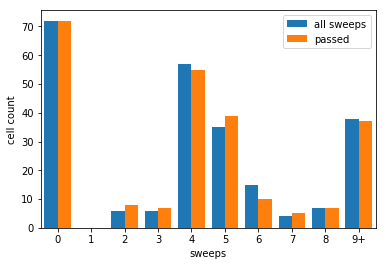

In [155]:
plot_qc_comparison(cells_df, "spiking", bins=np.arange(11))

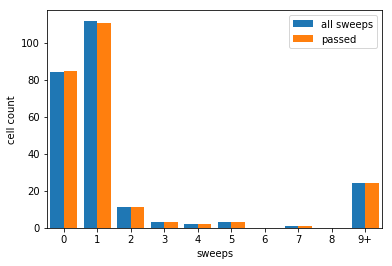

In [158]:
plot_qc_comparison(cells_df, "sub_depol", bins=np.arange(11))

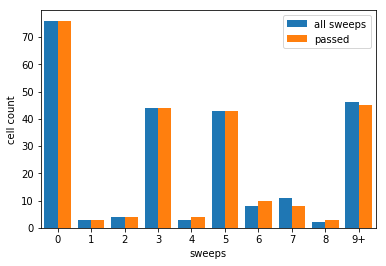

In [163]:
plot_qc_comparison(cells_df, "sub_hyper", bins=np.arange(11))

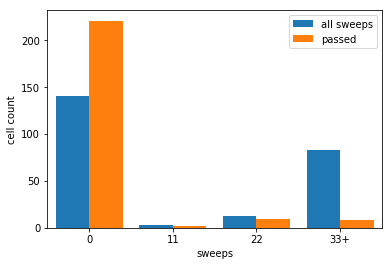

In [156]:
plot_qc_comparison(cells_df, "triblips", bins=11*np.arange(5))

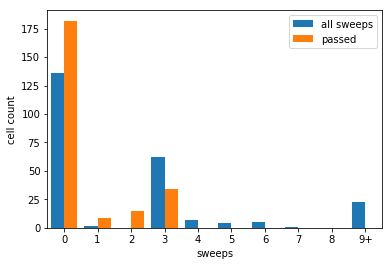

In [157]:
plot_qc_comparison(cells_df, "chirps", bins=np.arange(11))

## Plots of sweep counts by experiment date

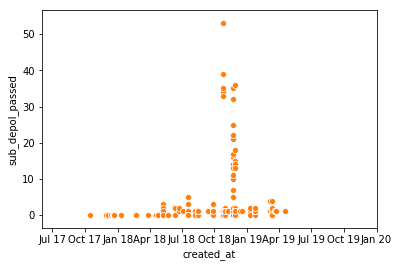

In [41]:
import matplotlib.dates as mdates
ax = sns.scatterplot(data=cells_df, x="created_at", y="sub_depol")
ax = sns.scatterplot(data=cells_df, x="created_at", y="sub_depol_passed")
ax.set_xlim(mdates.datetime.date(2017,6,1), mdates.datetime.date(2020,1,1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

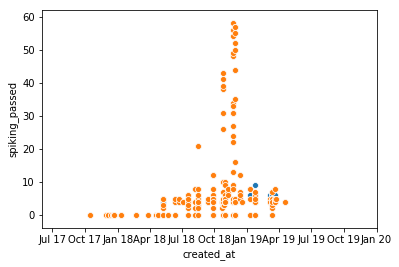

In [42]:
import matplotlib.dates as mdates
ax = sns.scatterplot(data=cells_df, x="created_at", y="spiking")
ax = sns.scatterplot(data=cells_df, x="created_at", y="spiking_passed")
ax.set_xlim(mdates.datetime.date(2017,6,1), mdates.datetime.date(2020,1,1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

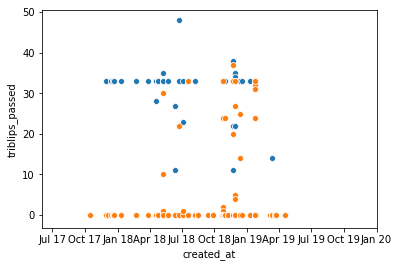

In [43]:
import matplotlib.dates as mdates
ax = sns.scatterplot(data=cells_df, x="created_at", y="triblips")
ax = sns.scatterplot(data=cells_df, x="created_at", y="triblips_passed")
ax.set_xlim(mdates.datetime.date(2017,6,1), mdates.datetime.date(2020,1,1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

## IPFX plot sweeps example

Use to visualize examples with no spiking sweeps recorded, or QC fails

In [23]:
from ipfx.aibs_data_set import AibsDataSet
from ipfx.stimulus import StimulusOntology
import ipfx.bin.lims_queries as lq
import allensdk.core.json_utilities as ju

In [24]:
cell_id = 695546566
nwb_file = lq.get_input_nwb_file(cell_id)
# nwb_file = lr.get_nwb_path_from_lims(cell_id)
ontology = StimulusOntology(ju.read(StimulusOntology.DEFAULT_STIMULUS_ONTOLOGY_FILE))
data_set = AibsDataSet(nwb_file=nwb_file, ontology=ontology)

from ipfx.data_set_utils import create_data_set
from ipfx.bin.plot_ephys_nwb import plot_data_set
%matplotlib tk
iclamp_sweep_table = data_set.sweep_table[data_set.sweep_table["clamp_mode"] == "CurrentClamp"]
plot_data_set(data_set, iclamp_sweep_table, nwb_file)
# plt.show()

In [55]:
sweep_table = data_set.sweep_table[data_set.sweep_table["clamp_mode"] == "VoltageClamp"]
plot_data_set(data_set, sweep_table, nwb_file)
# plt.show()